In [79]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, mean_squared_error, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV, KFold, learning_curve
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [80]:
# Read the CSV file in the same directory as the code
data = pd.read_csv('../data/The_Cancer_data_1500_V2.csv')
print("Dataset: ")
data.head()

Dataset: 


,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1


In [81]:
# Separate features and target
X = data.drop(columns='Diagnosis')
y = data['Diagnosis']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Below, I used GridSearchCV to perform an exhaustive search over a specified parameter grid to find the best hyperparameters for a model.

# I. Decision Tree

## Testing for best parameters for tuned decision tree model

In [82]:
# Define the parameter grid
param_grid = {
    'max_depth': [5, 10, 20, 30], # max depth of the tree
    'min_samples_split': [2, 5, 10, 20], # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6, 10], # minimum number of samples a node must have to become a leaf node
    'criterion': ['gini', 'entropy'], # function used to measure the quality of the split
    'max_features': [None, 'sqrt', 'log2'] # number of features to consider when looking for the best split at each node
}

In [83]:
# Output the best parameters found
decision_tree = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters from wide grid search:", grid_search.best_params_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best parameters from wide grid search: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [84]:
# Define the parameter grid that has best 2 features
param_grid_adjusted = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 6, 10],
}

In [85]:
# Initialize GridSearchCV with 5-fold cross-validation
grid_search_adjusted = GridSearchCV(estimator= decision_tree , 
                                    param_grid=param_grid_adjusted, 
                                    cv=5, 
                                    n_jobs=-1, 
                                    verbose=1, 
                                    scoring='accuracy')

grid_search_adjusted.fit(X_train, y_train)

print("Best parameters:", grid_search_adjusted.best_params_)
best_tree = grid_search_adjusted.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 4}


In [86]:
# Extract results from the grid search
cv_results = pd.DataFrame(grid_search_adjusted.cv_results_)

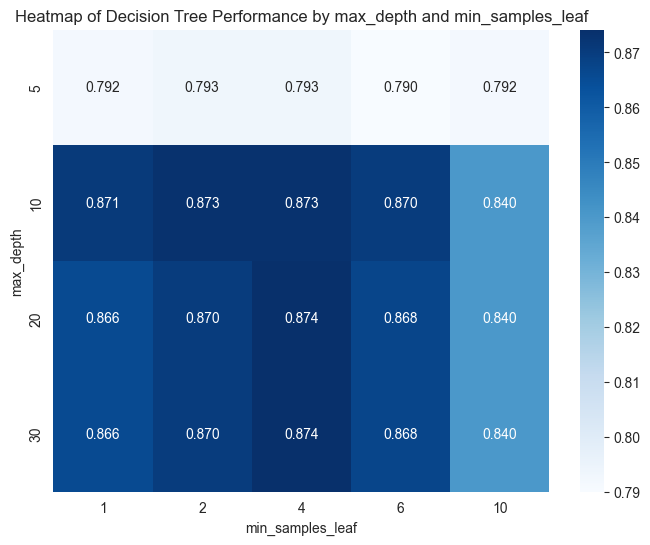

In [87]:
max_depth_values = cv_results['param_max_depth'].copy()

# Loop through each index in the column
for i in range(len(max_depth_values)):
    # Check if the current value is None
    if max_depth_values[i] is None:
        # Replace None with the string 'None'
        max_depth_values[i] = 'None'

pivot_table = cv_results.pivot_table(values='mean_test_score',
                                     index='param_max_depth',
                                     columns='param_min_samples_leaf',)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.3f')
plt.title("Heatmap of Decision Tree Performance by max_depth and min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.show()

## Train and evaluate the default Decision Tree training and test dataset

In [88]:
# Train and evaluate the default Decision Tree
tree = decision_tree
tree.fit(X_train, y_train)

# Calculate metrics for default DT on training data
y_pred_train_default_tree = tree.predict(X_train)
accuracy_train_default_tree = accuracy_score(y_train, y_pred_train_default_tree)
class_report_train_default_tree = classification_report(y_train, y_pred_train_default_tree)

# Calculate metrics for default DT on test data
y_pred_default_tree = tree.predict(X_test)
accuracy_test_default_tree = accuracy_score(y_test, y_pred_default_tree)
class_report_test_default_tree = classification_report(y_test, y_pred_default_tree)


In [89]:
# Print results for default model
print("Default Decision Tree Training Accuracy:", accuracy_train_default_tree)
print("Default Decision Tree Test Accuracy:", accuracy_test_default_tree)

print("\nDefault Decision Tree Training Classification Report:\n", class_report_train_default_tree)
print("\nDefault Decision Tree Test Classification Report:\n", class_report_test_default_tree)

mse_default_tree_train =  mean_squared_error(y_train, y_pred_train_default_tree)
mse_default_tree_test = mean_squared_error(y_test, y_pred_default_tree)

print("mse default decision tree train:", np.round(float(mse_default_tree_train),3))
print("mse default decision tree test data: ", np.round(float(mse_default_tree_test),3))

Default Decision Tree Training Accuracy: 1.0
Default Decision Tree Test Accuracy: 0.8766666666666667

Default Decision Tree Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       759
           1       1.00      1.00      1.00       441

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


Default Decision Tree Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       184
           1       0.87      0.80      0.83       116

    accuracy                           0.88       300
   macro avg       0.87      0.86      0.87       300
weighted avg       0.88      0.88      0.88       300

mse default decision tree train: 0.0
mse default decision tree test data:  0.123


## Train and evaluate the tuned Decision Tree

In [90]:
# Train and evaluate the tuned Decision Tree
best_tree = grid_search_adjusted.best_estimator_
best_tree.fit(X_train, y_train)

# Calculate metrics for tuned DT on training data
y_pred_train_best_tree = best_tree.predict(X_train)
accuracy_train_best_tree = accuracy_score(y_train, y_pred_train_best_tree)
class_report_train_best_tree = classification_report(y_train, y_pred_train_best_tree)

# Calculate metrics for tuned DT on test data
y_pred_best_tree = best_tree.predict(X_test)
accuracy_test_best_tree = accuracy_score(y_test, y_pred_best_tree)
class_report_test_best_tree = classification_report(y_test, y_pred_best_tree)

train_mse_best_tree = mean_squared_error(y_train, y_pred_train_best_tree)
mse_best_tree = mean_squared_error(y_test, y_pred_best_tree)

In [91]:
# Print results for tuned model
print("\nTuned Decision Tree Training Accuracy:", accuracy_train_best_tree)
print("Tuned Decision Tree Test Accuracy:", accuracy_test_best_tree)

print("\nTuned Decision Tree Training Classification Report:\n", class_report_train_best_tree)
print("\nTuned Decision Tree Test Classification Report:\n", class_report_test_best_tree)

print("Tuned Decision Tree MSE on Train Data:", train_mse_best_tree)
print("Tuned Decision Tree MSE on Test Data:", mse_best_tree)


Tuned Decision Tree Training Accuracy: 0.9541666666666667
Tuned Decision Tree Test Accuracy: 0.91

Tuned Decision Tree Training Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       759
           1       0.96      0.91      0.94       441

    accuracy                           0.95      1200
   macro avg       0.96      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200


Tuned Decision Tree Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       184
           1       0.93      0.83      0.88       116

    accuracy                           0.91       300
   macro avg       0.92      0.89      0.90       300
weighted avg       0.91      0.91      0.91       300

Tuned Decision Tree MSE on Train Data: 0.04583333333333333
Tuned Decision Tree MSE on Test Data: 0.09


## ROC for default and tuned Decision Tree

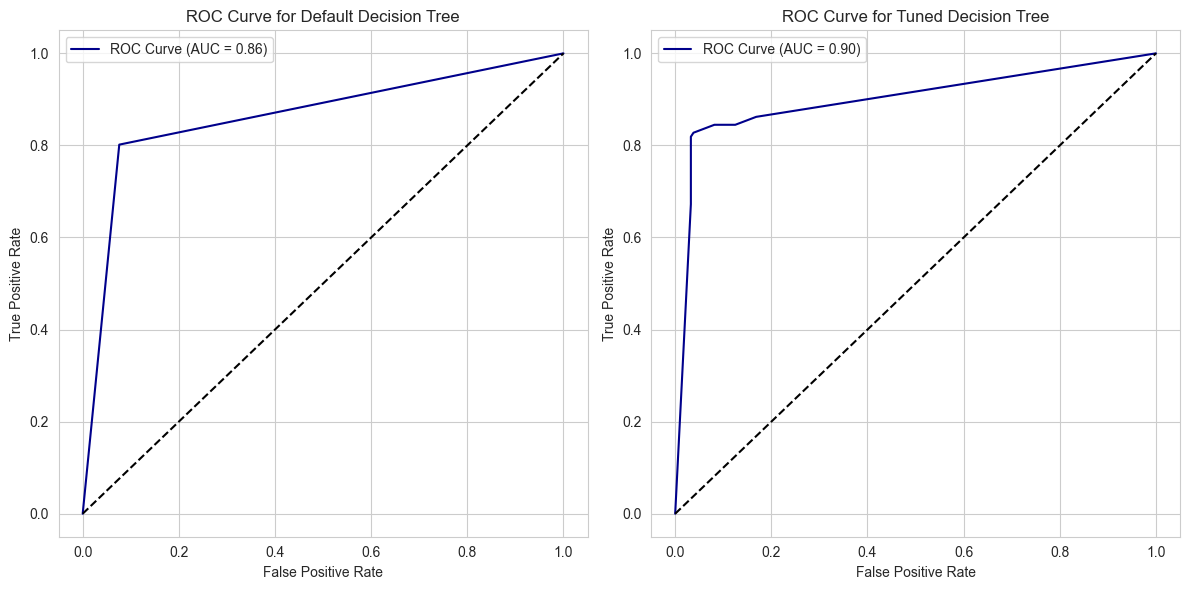

AUC Score for Default Decision Tree: 0.86
AUC Score for Tuned Decision Tree: 0.90


In [92]:
# Generate prediction probabilities for ROC curves
y_pred_prob_tree = tree.predict_proba(X_test)[:, 1]             # Default Decision Tree
y_pred_prob_best_tree = best_tree.predict_proba(X_test)[:, 1]   # Tuned Decision Tree

# Set up side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot ROC for Default Decision Tree
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_prob_tree)
auc_score_tree = roc_auc_score(y_test, y_pred_prob_tree)
ax1.plot(fpr_tree, tpr_tree, label=f"ROC Curve (AUC = {auc_score_tree:.2f})", color="darkblue")
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve for Default Decision Tree')
ax1.legend()

# Plot ROC for Tuned Decision Tree
fpr_best_tree, tpr_best_tree, _ = roc_curve(y_test, y_pred_prob_best_tree)
auc_score_best_tree = roc_auc_score(y_test, y_pred_prob_best_tree)
ax2.plot(fpr_best_tree, tpr_best_tree, label=f"ROC Curve (AUC = {auc_score_best_tree:.2f})", color="darkblue")
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve for Tuned Decision Tree')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Print AUC Scores for reference
print(f"AUC Score for Default Decision Tree: {auc_score_tree:.2f}")
print(f"AUC Score for Tuned Decision Tree: {auc_score_best_tree:.2f}")

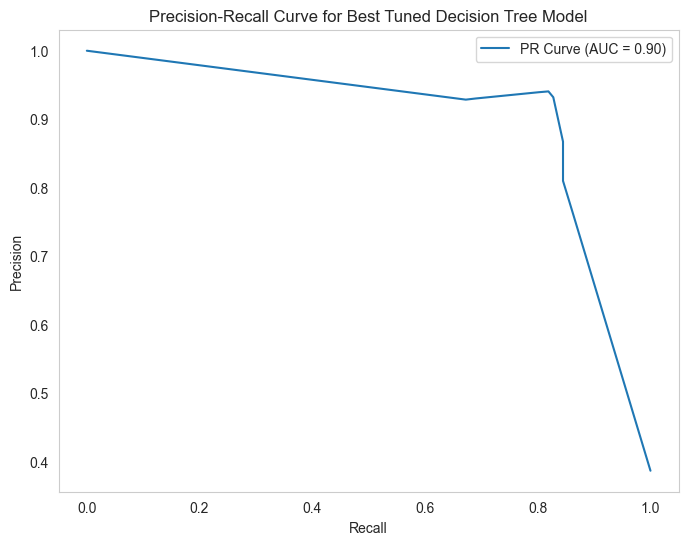

Area Under Precision-Recall Curve (AUC-PR): 0.90


In [93]:
# Generate prediction probabilities for Precision-Recall Curve
y_pred_prob_best_dt = best_tree.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_best_dt)

# Calculate the Area Under the Precision-Recall Curve
auc_pr = auc(recall, precision)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {auc_pr:.2f})')
plt.title('Precision-Recall Curve for Best Tuned Decision Tree Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

# Optionally: Display AUC-PR value
print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")


## Confusion Matrices of Default and Tuned Decision Tree Model

<Figure size 1000x500 with 0 Axes>

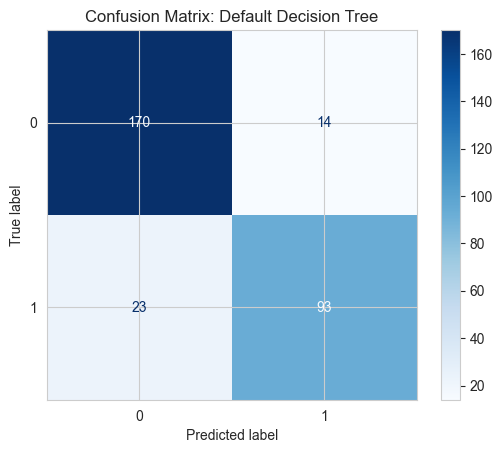

<Figure size 1000x500 with 0 Axes>

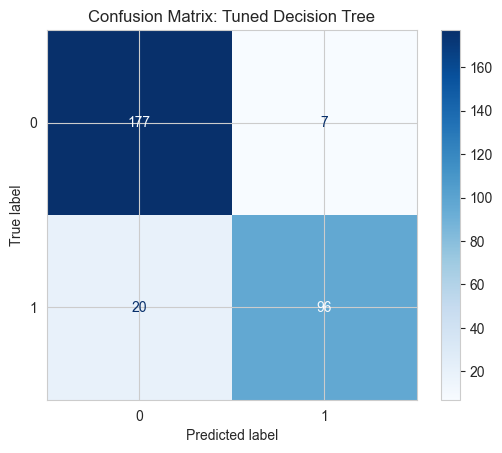

In [94]:
# Visualize confusion matrices
plt.figure(figsize=(10, 5))
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, cmap = "Blues")
plt.title("Confusion Matrix: Default Decision Tree")
plt.show()

plt.figure(figsize=(10, 5))
ConfusionMatrixDisplay.from_estimator(best_tree, X_test, y_test, cmap = "Blues")
plt.title("Confusion Matrix: Tuned Decision Tree")
plt.show()

## Learning Curve of Default and Tuned Decision Tree Model

In [95]:
# Generate learning curve for a default decision tree (without tuning)
default_tree = DecisionTreeClassifier(random_state=42)  # Using default hyperparameters
default_train_sizes, default_train_scores, default_val_scores = learning_curve(
    default_tree, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Generate learning curve for the best tree from grid search
train_sizes, best_train_scores, best_val_scores = learning_curve(
    best_tree, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for the best tree
best_train_mean = np.mean(best_train_scores, axis=1)
best_train_std = np.std(best_train_scores, axis=1)
best_val_mean = np.mean(best_val_scores, axis=1)
best_val_std = np.std(best_val_scores, axis=1)

# Calculate mean and std for the default tree
default_train_mean = np.mean(default_train_scores, axis=1)
default_train_std = np.std(default_train_scores, axis=1)
default_val_mean = np.mean(default_val_scores, axis=1)
default_val_std = np.std(default_val_scores, axis=1)

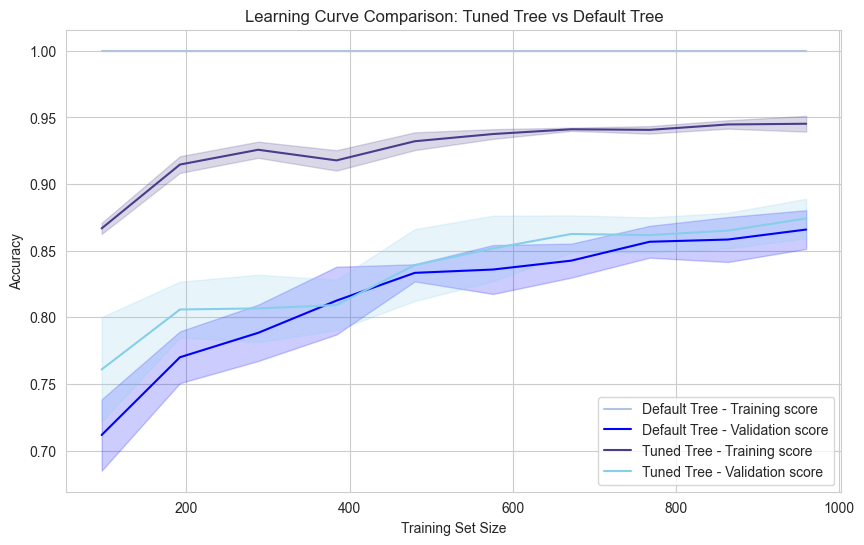

In [96]:
# Plot learning curves for both models
plt.figure(figsize=(10, 6))

# Plot for the default tree
plt.plot(default_train_sizes, default_train_mean, label="Default Tree - Training score", color="lightsteelblue")
plt.plot(default_train_sizes, default_val_mean, label="Default Tree - Validation score", color="blue")
plt.fill_between(default_train_sizes, default_train_mean - default_train_std, default_train_mean + default_train_std, alpha=0.2, color="lightsteelblue")
plt.fill_between(default_train_sizes, default_val_mean - default_val_std, default_val_mean + default_val_std, alpha=0.2, color="blue")

# Plot for the best tree (grid search optimized)
plt.plot(train_sizes, best_train_mean, label="Tuned Tree - Training score", color="darkslateblue")
plt.plot(train_sizes, best_val_mean, label="Tuned Tree - Validation score", color="skyblue")
plt.fill_between(train_sizes, best_train_mean - best_train_std, best_train_mean + best_train_std, alpha=0.2, color="darkslateblue")
plt.fill_between(train_sizes, best_val_mean - best_val_std, best_val_mean + best_val_std, alpha=0.2, color="skyblue")

# Plot details
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve Comparison: Tuned Tree vs Default Tree")

plt.show()

# II. Random Forest

## Testing for best parameters for tuned Random Forest model

In [97]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [98]:
# Initialize the RandomForestClassifier
random_forest = RandomForestClassifier(random_state=42)

# Set up GridSearchCV for Random Forest with 5-fold cross-validation
grid_search_rf = GridSearchCV(
    estimator=random_forest, 
    param_grid=param_grid_rf, 
    cv=5, 
    n_jobs=-1, 
    verbose=1,
    scoring='accuracy'
)

# Fit the grid search to the training data
grid_search_rf.fit(X_train, y_train)

# Output the best parameters found
print("Best parameters from Grid Search for Random Forest:", grid_search_rf.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters from Grid Search for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [99]:
# Define the best parameter grid for Random Forest
best_param_grid_rf = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [100]:
grid_search_rf = GridSearchCV(
    estimator=random_forest, 
    param_grid=best_param_grid_rf, 
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Print progress
    scoring='accuracy'  # or another metric if desired
)

grid_search_rf.fit(X_train, y_train)

print("Best parameters found by GridSearchCV:", grid_search_rf.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found by GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


## Train and evaluate the default and tuned Random Forest model

In [101]:
# Train and evaluate the default Random Forest model
default_rf = random_forest
default_rf.fit(X_train, y_train)

# Calculate metrics for default RF on training data
y_pred_train_default_rf = default_rf.predict(X_train)
accuracy_train_default_rf = accuracy_score(y_train, y_pred_train_default_rf)
classification_report_train_default_rf = classification_report(y_train, y_pred_train_default_rf)
mse_train_default_rf = mean_squared_error(y_train, y_pred_train_default_rf)

# Calculate metrics for default RF on test data
y_pred_default_rf = default_rf.predict(X_test)
accuracy_test_default_rf = accuracy_score(y_test, y_pred_default_rf)
classification_report_test_default_rf = classification_report(y_test, y_pred_default_rf)
mse_test_default_rf = mean_squared_error(y_test, y_pred_default_rf)

In [102]:
# Print results for the default Random Forest model
print("Default Random Forest Training Accuracy:", accuracy_train_default_rf)
print("Default Random Forest Test Accuracy:", accuracy_test_default_rf)

print("\nDefault Random Forest Training Classification Report:\n", classification_report_train_default_rf)
print("\nDefault Random Forest Test Classification Report:\n", classification_report_test_default_rf)

print("Default Random Forest MSE on Training Data:", mse_train_default_rf)
print("Default Random Forest MSE on Test Data:", mse_test_default_rf)

Default Random Forest Training Accuracy: 1.0
Default Random Forest Test Accuracy: 0.93

Default Random Forest Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       759
           1       1.00      1.00      1.00       441

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


Default Random Forest Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       184
           1       0.94      0.88      0.91       116

    accuracy                           0.93       300
   macro avg       0.93      0.92      0.93       300
weighted avg       0.93      0.93      0.93       300

Default Random Forest MSE on Training Data: 0.0
Default Random Forest MSE on Test Data: 0.07


In [103]:
# Hyperparameter tuning using GridSearchCV
best_rf = grid_search_rf.best_estimator_

# Calculate metrics for tuned RF on training data
y_pred_train_best_rf = best_rf.predict(X_train)
accuracy_train_best_rf = accuracy_score(y_train, y_pred_train_best_rf)
classification_report_train_best_rf = classification_report(y_train, y_pred_train_best_rf)
mse_train_best_rf = mean_squared_error(y_train, y_pred_train_best_rf)

# Calculate metrics for tuned RF on test data
y_pred_best_rf = best_rf.predict(X_test)
accuracy_test_best_rf = accuracy_score(y_test, y_pred_best_rf)
classification_report_test_best_rf = classification_report(y_test, y_pred_best_rf)
mse_test_best_rf = mean_squared_error(y_test, y_pred_best_rf)

In [104]:
# Print results for the tuned Random Forest model
print("\nTuned Random Forest Training Accuracy:", accuracy_train_best_rf)
print("\nTuned Random Forest Test Accuracy:", accuracy_test_best_rf)
print("\nTuned Random Forest Training Classification Report:\n", classification_report_train_best_rf)
print("\nTuned Random Forest Test Classification Report:\n", classification_report_test_best_rf)
print("Tuned Random Forest MSE on Training Data:", mse_train_best_rf)
print("Tuned Random Forest MSE on Test Data:", mse_test_best_rf)


Tuned Random Forest Training Accuracy: 0.9825

Tuned Random Forest Test Accuracy: 0.9233333333333333

Tuned Random Forest Training Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       759
           1       1.00      0.95      0.98       441

    accuracy                           0.98      1200
   macro avg       0.99      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200


Tuned Random Forest Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       184
           1       0.93      0.86      0.90       116

    accuracy                           0.92       300
   macro avg       0.93      0.91      0.92       300
weighted avg       0.92      0.92      0.92       300

Tuned Random Forest MSE on Training Data: 0.0175
Tuned Random Forest MSE on Test Data: 0.07666666666666666


## ROC and AUC of default and tuned Random Forest Model

In [105]:
# Train the default Random Forest and the tuned Random Forest
default_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
best_rf.fit(X_train, y_train)

# Generate prediction probabilities for ROC curves
y_pred_prob_default_rf = default_rf.predict_proba(X_test)[:, 1]         # Default Random Forest
y_pred_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]               # Tuned Random Forest

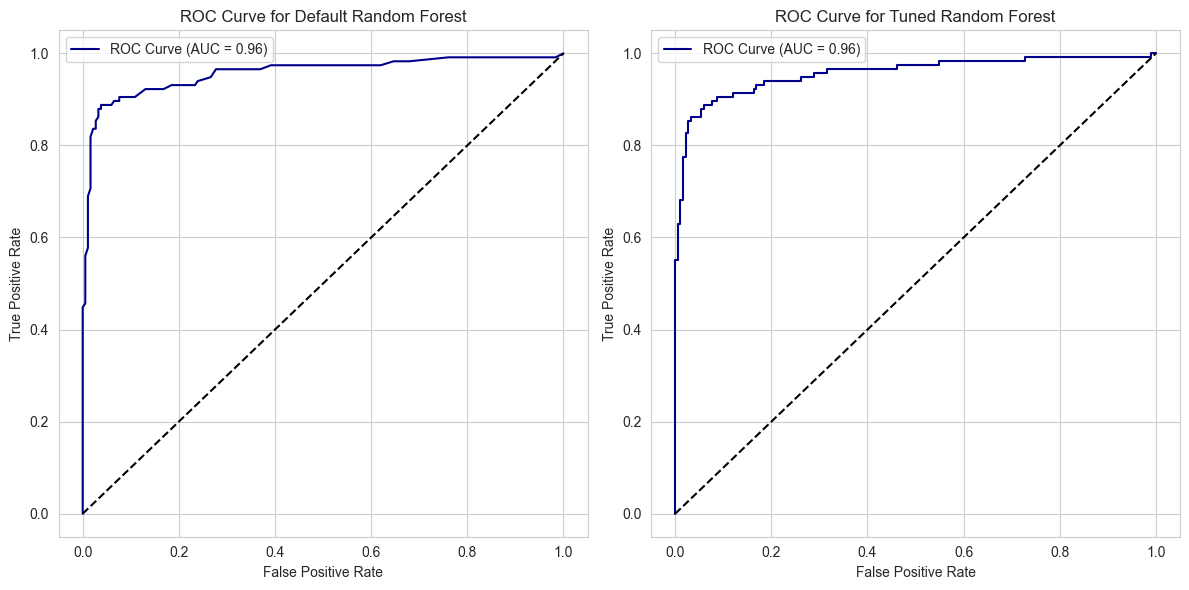

AUC Score for Default Random Forest: 0.96
AUC Score for Tuned Random Forest: 0.96


In [106]:

# Set up side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot ROC for Default Random Forest
fpr_default_rf, tpr_default_rf, _ = roc_curve(y_test, y_pred_prob_default_rf)
auc_score_default_rf = roc_auc_score(y_test, y_pred_prob_default_rf)
ax1.plot(fpr_default_rf, tpr_default_rf, label=f"ROC Curve (AUC = {auc_score_default_rf:.2f})", color="darkblue")
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve for Default Random Forest')
ax1.legend(loc="best")

# Plot ROC for Tuned Random Forest
fpr_best_rf, tpr_best_rf, _ = roc_curve(y_test, y_pred_prob_best_rf)
auc_score_best_rf = roc_auc_score(y_test, y_pred_prob_best_rf)
ax2.plot(fpr_best_rf, tpr_best_rf, label=f"ROC Curve (AUC = {auc_score_best_rf:.2f})", color="darkblue")
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve for Tuned Random Forest')
ax2.legend(loc="best")

plt.tight_layout()
plt.show()

print(f"AUC Score for Default Random Forest: {auc_score_default_rf:.2f}")
print(f"AUC Score for Tuned Random Forest: {auc_score_best_rf:.2f}")

## Confusion Matrix of default and tuned Random Forest model

<Figure size 800x600 with 0 Axes>

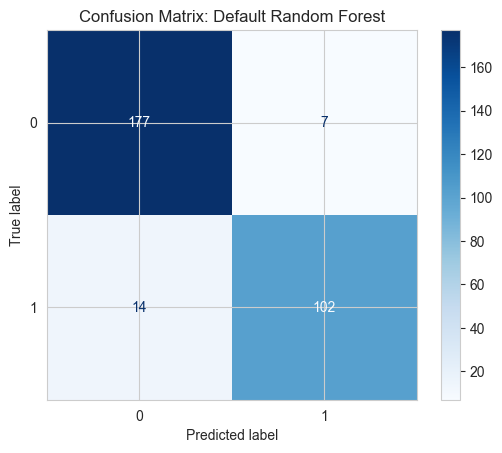

<Figure size 800x600 with 0 Axes>

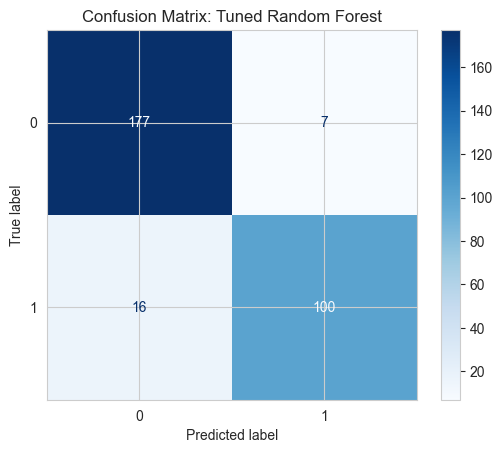

In [107]:
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(default_rf, X_test, y_test, cmap = "Blues")
plt.title("Confusion Matrix: Default Random Forest")

plt.show()

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap = "Blues")
plt.title("Confusion Matrix: Tuned Random Forest")

plt.show()

In [108]:
# Generate learning curve for a default and tuned Random Forest
default_rf_train_sizes, default_rf_train_scores, default_rf_val_scores = learning_curve(
    default_rf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

tuned_rf_train_sizes, tuned_rf_train_scores, tuned_rf_val_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for the default Random Forest
default_rf_train_mean = np.mean(default_rf_train_scores, axis=1)
default_rf_train_std = np.std(default_rf_train_scores, axis=1)
default_rf_val_mean = np.mean(default_rf_val_scores, axis=1)
default_rf_val_std = np.std(default_rf_val_scores, axis=1)

# Calculate mean and std for the tuned Random Forest
tuned_rf_train_mean = np.mean(tuned_rf_train_scores, axis=1)
tuned_rf_train_std = np.std(tuned_rf_train_scores, axis=1)
tuned_rf_val_mean = np.mean(tuned_rf_val_scores, axis=1)
tuned_rf_val_std = np.std(tuned_rf_val_scores, axis=1)

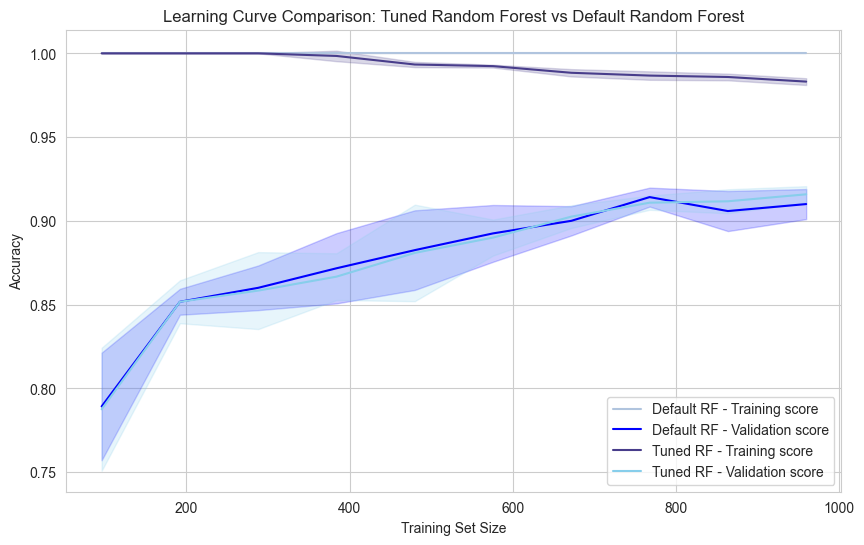

In [109]:

# Plot learning curves for both models
plt.figure(figsize=(10, 6))

# Plot for the default Random Forest
plt.plot(default_rf_train_sizes, default_rf_train_mean, label="Default RF - Training score", color="lightsteelblue")
plt.plot(default_rf_train_sizes, default_rf_val_mean, label="Default RF - Validation score", color="blue")
plt.fill_between(default_rf_train_sizes, 
                 default_rf_train_mean - default_rf_train_std, 
                 default_rf_train_mean + default_rf_train_std, 
                 alpha=0.2, color="lightsteelblue")
plt.fill_between(default_rf_train_sizes, 
                 default_rf_val_mean - default_rf_val_std, 
                 default_rf_val_mean + default_rf_val_std, 
                 alpha=0.2, color="blue")

# Plot for the tuned Random Forest
plt.plot(tuned_rf_train_sizes, tuned_rf_train_mean, label="Tuned RF - Training score", color="darkslateblue")
plt.plot(tuned_rf_train_sizes, tuned_rf_val_mean, label="Tuned RF - Validation score", color="skyblue")
plt.fill_between(tuned_rf_train_sizes, 
                 tuned_rf_train_mean - tuned_rf_train_std, 
                 tuned_rf_train_mean + tuned_rf_train_std, 
                 alpha=0.2, color="darkslateblue")
plt.fill_between(tuned_rf_train_sizes, 
                 tuned_rf_val_mean - tuned_rf_val_std, 
                 tuned_rf_val_mean + tuned_rf_val_std, 
                 alpha=0.2, color="skyblue")

# Plot details
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve Comparison: Tuned Random Forest vs Default Random Forest")

plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Tuned Random Forest Training Accuracy: 0.9825

Tuned Random Forest Test Accuracy: 0.9233333333333333

Tuned Random Forest Training Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       759
           1       1.00      0.95      0.98       441

    accuracy                           0.98      1200
   macro avg       0.99      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200


Tuned Random Forest Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       184
           1       0.93      0.86      0.90       116

    accuracy                           0.92       300
   macro avg       0.93      0.91      0.92       300
weighted avg       0.92      0.92      0.92       300

Tuned Random Forest MSE on Training Data: 0.0175
Tuned Random Forest MSE on Te

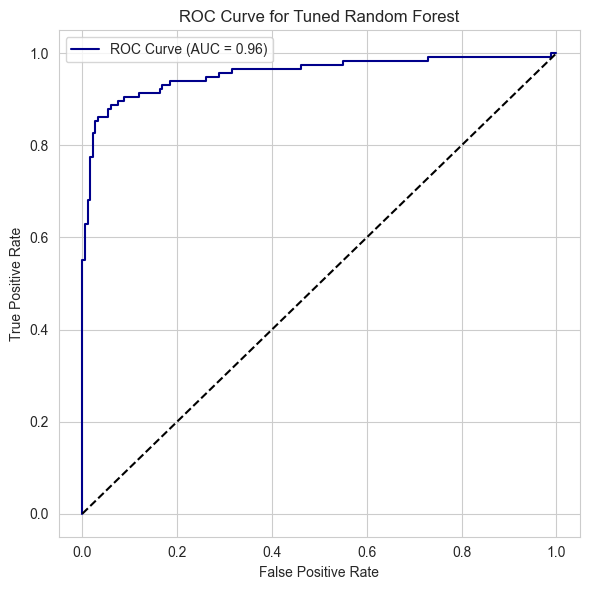

AUC Score for Tuned Random Forest: 0.96


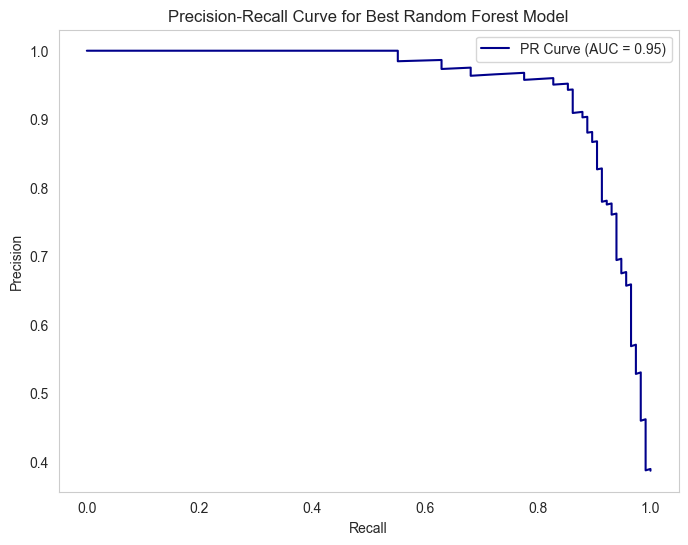

Area Under Precision-Recall Curve (AUC-PR): 0.95


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, mean_squared_error, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, learning_curve
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

# Read the CSV file in the same directory as the code
data = pd.read_csv('../data/The_Cancer_data_1500_V2.csv')

# Separate features and target
X = data.drop(columns='Diagnosis')
y = data['Diagnosis']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the best parameter grid for Random Forest
best_param_grid_rf = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search_rf = GridSearchCV(
    estimator=random_forest,
    param_grid=best_param_grid_rf,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Print progress
    scoring='accuracy'  # or another metric if desired
)

grid_search_rf.fit(X_train, y_train)

# Hyperparameter tuning using GridSearchCV
best_rf = grid_search_rf.best_estimator_

# Calculate metrics for tuned RF on training data
y_pred_train_best_rf = best_rf.predict(X_train)
accuracy_train_best_rf = accuracy_score(y_train, y_pred_train_best_rf)
classification_report_train_best_rf = classification_report(y_train, y_pred_train_best_rf)
mse_train_best_rf = mean_squared_error(y_train, y_pred_train_best_rf)

# Calculate metrics for tuned RF on test data
y_pred_best_rf = best_rf.predict(X_test)
accuracy_test_best_rf = accuracy_score(y_test, y_pred_best_rf)
classification_report_test_best_rf = classification_report(y_test, y_pred_best_rf)
mse_test_best_rf = mean_squared_error(y_test, y_pred_best_rf)

# Generate prediction probabilities for ROC curves
y_pred_prob_default_rf = default_rf.predict_proba(X_test)[:, 1]         # Default Random Forest
y_pred_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]    
# Print results for the tuned Random Forest model
print("\nTuned Random Forest Training Accuracy:", accuracy_train_best_rf)
print("\nTuned Random Forest Test Accuracy:", accuracy_test_best_rf)
print("\nTuned Random Forest Training Classification Report:\n", classification_report_train_best_rf)
print("\nTuned Random Forest Test Classification Report:\n", classification_report_test_best_rf)
print("Tuned Random Forest MSE on Training Data:", mse_train_best_rf)
print("Tuned Random Forest MSE on Test Data:", mse_test_best_rf)
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

# Plot ROC for Tuned Random Forest
fpr_best_rf, tpr_best_rf, _ = roc_curve(y_test, y_pred_prob_best_rf)
auc_score_best_rf = roc_auc_score(y_test, y_pred_prob_best_rf)
ax1.plot(fpr_best_rf, tpr_best_rf, label=f"ROC Curve (AUC = {auc_score_best_rf:.2f})", color="darkblue")
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve for Tuned Random Forest')
ax1.legend(loc="best")

plt.tight_layout()
plt.show()

print(f"AUC Score for Tuned Random Forest: {auc_score_best_rf:.2f}")
# Generate prediction probabilities for Precision-Recall Curve
y_pred_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_best_rf)

# Calculate the Area Under the Precision-Recall Curve
auc_pr = auc(recall, precision)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {auc_pr:.2f})', color = "darkblue")
plt.title('Precision-Recall Curve for Best Random Forest Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

# Optionally: Display AUC-PR value
print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")